In [1]:
import pandas as pd
import re
import os
import time
import random
import numpy as np

try:
  %tensorflow_version 2.x 
except Exception:
  pass


import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import pickle

import spacy

nlp = spacy.load("en_core_web_sm")
from nltk.translate.bleu_score import corpus_bleu

In [2]:
with open('MAWPS_Augmented.pkl', 'rb') as f:
  df = pickle.load(f)

In [3]:
df.shape

(38144, 2)

In [4]:
df.head(20)

,Question,Equation
963,A painter needed to paint 12 rooms in a build...,X=(7.0*(12.0-5.0))
3897,Brenda had 253 raspberry. John gripped some ra...,X = 253 - 66
27626,Casey wants to share some Bread among 17 frien...,X = 39 * 17
32530,Liza had 34 Press. Thomas furnished him some m...,X = 64 - 34
16266,George wants to distribute 125 mangos among 25...,X = 125 / 25
21122,Richard has 148 Marbles. Gary gave him 42 more...,X = 42 + 148
17377,Mary wants to impart 547 limes among 24 friend...,X = 547 / 24
20997,Juana had some apricot. He hash each apricot i...,X = 149 / 9
2745,Timmy had 86 watermelon. Kandi took 40 from hi...,X = 86 - 40
2080,William had 99 pear. Martin took 67 from him. ...,X = 99 - 67


In [5]:
X = list(df['Question'].values)

In [6]:
def spacify(s):
    return ' '.join(list(s))

In [7]:
Y = list(df['Equation'].apply(lambda y: spacify(y)).values)

In [8]:

print(X[:10])
Y[:10]

[' A painter needed to paint 12 rooms in a building. Each room takes 7 hours to paint. If he already painted 5 rooms, how much longer will he take to paint the rest? ', 'Brenda had 253 raspberry. John gripped some raspberry. Now Brenda has 66  raspberry. How many did John grippeds?', 'Casey wants to share some Bread among 17 friends.If each friend get 39 Bread, then how many Bread john would have?', 'Liza had 34 Press. Thomas furnished him some more. Now Liza has 64 Press. How many did Thomas furnish him?', 'George wants to distribute 125 mangos among 25 friends. How many would each friend acquire?', 'Richard has 148 Marbles. Gary gave him 42 more. How many Marbles does Richard have altogether?', 'Mary wants to impart 547 limes among 24 friends. How many would each friend obtain?', 'Juana had some apricot. He hash each apricot into 9 slices. If total 149 apricot slices Juana make, then how many apricot Juana had?', 'Timmy had 86 watermelon. Kandi took 40 from him. Now How many watermel

['X = ( 7 . 0 * ( 1 2 . 0 - 5 . 0 ) )',
 'X   =   2 5 3   -   6 6',
 'X   =   3 9   *   1 7',
 'X   =   6 4   -   3 4',
 'X   =   1 2 5   /   2 5',
 'X   =   4 2   +   1 4 8',
 'X   =   5 4 7   /   2 4',
 'X   =   1 4 9   /   9',
 'X   =   8 6   -   4 0',
 'X   =   9 9   -   6 7']

In [9]:
def preprocess_X(s):
    s = s.lower().strip()
    s = re.sub(r"([?.!,’])", r" \1 ", s)
    s = re.sub(r"([0-9])", r" \1 ", s)
    s = re.sub(r'[" "]+', " ", s)
    s = s.rstrip().strip()
    return s

def preprocess_Y(e):
    e = e.lower().strip()
    return e

In [10]:
X_pp = list(map(preprocess_X, X))
Y_pp = list(map(preprocess_Y, Y))

In [11]:
X_pp[:10]

['a painter needed to paint 1 2 rooms in a building . each room takes 7 hours to paint . if he already painted 5 rooms , how much longer will he take to paint the rest ?',
 'brenda had 2 5 3 raspberry . john gripped some raspberry . now brenda has 6 6 raspberry . how many did john grippeds ?',
 'casey wants to share some bread among 1 7 friends . if each friend get 3 9 bread , then how many bread john would have ?',
 'liza had 3 4 press . thomas furnished him some more . now liza has 6 4 press . how many did thomas furnish him ?',
 'george wants to distribute 1 2 5 mangos among 2 5 friends . how many would each friend acquire ?',
 'richard has 1 4 8 marbles . gary gave him 4 2 more . how many marbles does richard have altogether ?',
 'mary wants to impart 5 4 7 limes among 2 4 friends . how many would each friend obtain ?',
 'juana had some apricot . he hash each apricot into 9 slices . if total 1 4 9 apricot slices juana make , then how many apricot juana had ?',
 'timmy had 8 6 water

In [12]:
Y_pp[:10]

['x = ( 7 . 0 * ( 1 2 . 0 - 5 . 0 ) )',
 'x   =   2 5 3   -   6 6',
 'x   =   3 9   *   1 7',
 'x   =   6 4   -   3 4',
 'x   =   1 2 5   /   2 5',
 'x   =   4 2   +   1 4 8',
 'x   =   5 4 7   /   2 4',
 'x   =   1 4 9   /   9',
 'x   =   8 6   -   4 0',
 'x   =   9 9   -   6 7']

In [13]:
def tokenize(lang):
    lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    lang_tokenizer.fit_on_texts(lang)
    tensor = lang_tokenizer.texts_to_sequences(lang)
    return tensor, lang_tokenizer

In [14]:
X_tensor, X_lang_tokenizer = tokenize(X_pp)

In [15]:
len(X_lang_tokenizer.word_index)

5887

In [16]:
Y_tensor, Y_lang_tokenizer = tokenize(Y_pp)

In [17]:
len(Y_lang_tokenizer.word_index)

45

In [18]:
previous_length = len(Y_lang_tokenizer.word_index)

In [20]:
def append_head_tail(x, last_int):
    l = []
    l.append(last_int + 1)
    l.extend(x)
    l.append(last_int + 2)
    return l

In [21]:
X_tensor_list = [append_head_tail(i, len(X_lang_tokenizer.word_index)) for i in X_tensor]
Y_tensor_list = [append_head_tail(i, len(Y_lang_tokenizer.word_index)) for i in Y_tensor]

In [22]:
X_tensor = tf.keras.preprocessing.sequence.pad_sequences(X_tensor_list, padding='post')
Y_tensor = tf.keras.preprocessing.sequence.pad_sequences(Y_tensor_list, padding='post')

In [23]:
X_tensor

array([[5888,  104, 2454, ...,    0,    0,    0],
       [5888,  280,    6, ...,    0,    0,    0],
       [5888,  811,   43, ...,    0,    0,    0],
       ...,
       [5888,  380,   12, ...,    0,    0,    0],
       [5888,  167,    6, ...,    0,    0,    0],
       [5888,  404,    6, ...,    0,    0,    0]])

In [24]:
Y_tensor

array([[46,  2,  1, ...,  0,  0,  0],
       [46,  2,  1, ...,  0,  0,  0],
       [46,  2,  1, ...,  0,  0,  0],
       ...,
       [46,  2,  1, ...,  0,  0,  0],
       [46,  2,  1, ...,  0,  0,  0],
       [46,  2,  1, ...,  0,  0,  0]])

In [25]:
keys = ['10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21',
        '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33',
        '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45',
        '46', '47', '48', '49', '50']

for idx,key in enumerate(keys):
    Y_lang_tokenizer.word_index[key] = len(Y_lang_tokenizer.word_index) + idx + 4

In [26]:
len(Y_lang_tokenizer.word_index)

86

In [27]:
X_tensor_train, X_tensor_test, Y_tensor_train, Y_tensor_test = train_test_split(X_tensor, Y_tensor, test_size=0.05, random_state=42)

In [28]:
print(len(X_tensor_train), len(X_tensor_test), len(Y_tensor_train), len(Y_tensor_test)) 

36236 1908 36236 1908


In [29]:
TRAINING_SET_SIZE = len(X_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = np.floor(TRAINING_SET_SIZE/BATCH_SIZE)

data = tf.data.Dataset.from_tensor_slices((X_tensor_train, Y_tensor_train)).shuffle(TRAINING_SET_SIZE)
data = data.batch(BATCH_SIZE, drop_remainder=True)

num_layers = 4
d_model = 128       # Embedding dimension
dff = 512           # Dimensionality of inner-layer of FNN
num_heads = 8       # Number of parallel attention layers (heads)
dropout_rate = 0

X_vocabulary_size = len(X_lang_tokenizer.word_index) + 3
Y_vocabulary_size = len(Y_lang_tokenizer.word_index) + 3

In [30]:
data = data.prefetch(tf.data.experimental.AUTOTUNE)

In [31]:
data

<PrefetchDataset element_spec=(TensorSpec(shape=(64, 124), dtype=tf.int32, name=None), TensorSpec(shape=(64, 66), dtype=tf.int32, name=None))>

In [32]:
X_batch_example, Y_batch_example = next(iter(data))

print(X_batch_example, Y_batch_example)

tf.Tensor(
[[5888 1385   12 ...    0    0    0]
 [5888  165  624 ...    0    0    0]
 [5888  670   43 ...    0    0    0]
 ...
 [5888  637    6 ...    0    0    0]
 [5888 1472    6 ...    0    0    0]
 [5888  436   12 ...    0    0    0]], shape=(64, 124), dtype=int32) tf.Tensor(
[[46  2  1 ...  0  0  0]
 [46  2  1 ...  0  0  0]
 [46  2  1 ...  0  0  0]
 ...
 [46  2  1 ...  0  0  0]
 [46  2  1 ...  0  0  0]
 [46  2  1 ...  0  0  0]], shape=(64, 66), dtype=int32)


In [33]:
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates

In [34]:
def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                            np.arange(d_model)[np.newaxis, :],
                            d_model)
    
    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    
    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
        
    pos_encoding = angle_rads[np.newaxis, ...]
        
    return tf.cast(pos_encoding, dtype=tf.float32)

In [35]:
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    
    # add extra dimensions to add the padding
    # to the attention logits.
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [36]:
def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask

In [37]:
def scaled_dot_product_attention(q, k, v, mask):
    matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
    
    # scale matmul_qk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    # add the mask to the scaled tensor.
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)  

    # softmax is normalized on the last axis (seq_len_k) so that the scores
    # add up to 1.
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

    return output, attention_weights

In [38]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        
        assert d_model % self.num_heads == 0
        
        self.depth = d_model // self.num_heads
        
        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)
        
        self.dense = tf.keras.layers.Dense(d_model)
            
    def split_heads(self, x, batch_size):
        """Split the last dimension into (num_heads, depth).
        Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
        
    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]
        
        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)
        
        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)
        
    
        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)
        
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

        concat_attention = tf.reshape(scaled_attention, 
                                    (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)
            
        return output, attention_weights

In [39]:
def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
        tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
    ])

In [40]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        # normalize data per feature instead of batch
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        
    def call(self, x, training, mask):
        # Multi-head attention layer
        attn_output, _ = self.mha(x, x, x, mask) 
        attn_output = self.dropout1(attn_output, training=training)
        # add residual connection to avoid vanishing gradient problem
        out1 = self.layernorm1(x + attn_output)
        
        # Feedforward layer
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        # add residual connection to avoid vanishing gradient problem
        out2 = self.layernorm2(out1 + ffn_output)
        return out2

In [41]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
                maximum_position_encoding, rate=0.1):
        super(Encoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers
        
        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, 
                                                self.d_model)
        
        # Create encoder layers (count: num_layers)
        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) 
                        for _ in range(num_layers)]
    
        self.dropout = tf.keras.layers.Dropout(rate)
            
    def call(self, x, training, mask):

        seq_len = tf.shape(x)[1]

        # adding embedding and position encoding.
        x = self.embedding(x)  
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)
        
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)
        
        return x

In [42]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)

        self.ffn = point_wise_feed_forward_network(d_model, dff)
    
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)
        
        
    def call(self, x, enc_output, training, 
            look_ahead_mask, padding_mask):

        # Masked multihead attention layer (padding + look-ahead)
        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)
        attn1 = self.dropout1(attn1, training=training)
        # again add residual connection
        out1 = self.layernorm1(attn1 + x)
        
        # Masked multihead attention layer (only padding)
        # with input from encoder as Key and Value, and input from previous layer as Query
        attn2, attn_weights_block2 = self.mha2(
            enc_output, enc_output, out1, padding_mask)
        attn2 = self.dropout2(attn2, training=training)
        # again add residual connection
        out2 = self.layernorm2(attn2 + out1)
        
        # Feedforward layer
        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output, training=training)
        # again add residual connection
        out3 = self.layernorm3(ffn_output + out2)
        return out3, attn_weights_block1, attn_weights_block2

In [43]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
                maximum_position_encoding, rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers
        
        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)
        
        # Create decoder layers (count: num_layers)
        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) 
                        for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)
        
    def call(self, x, enc_output, training, 
            look_ahead_mask, padding_mask):

        seq_len = tf.shape(x)[1]
        attention_weights = {}
        
        x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
        
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        
        x += self.pos_encoding[:,:seq_len,:]
        
        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                                look_ahead_mask, padding_mask)
        
        # store attenion weights, they can be used to visualize while translating
        attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
        attention_weights['decoder_layer{}_block2'.format(i+1)] = block2
        
        return x, attention_weights

In [44]:
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, 
                target_vocab_size, pe_input, pe_target, rate=0.1):
        super(Transformer, self).__init__()

        self.encoder = Encoder(num_layers, d_model, num_heads, dff, 
                            input_vocab_size, pe_input, rate)

        self.decoder = Decoder(num_layers, d_model, num_heads, dff, 
                            target_vocab_size, pe_target, rate)

        self.final_layer = tf.keras.layers.Dense(target_vocab_size)
        
    def call(self, inp, tar, training, enc_padding_mask, 
            look_ahead_mask, dec_padding_mask):

        # Pass the input to the encoder
        enc_output = self.encoder(inp, training, enc_padding_mask)
        
        # Pass the encoder output to the decoder
        dec_output, attention_weights = self.decoder(
            tar, enc_output, training, look_ahead_mask, dec_padding_mask)
        
        # Pass the decoder output to the last linear layer
        final_output = self.final_layer(dec_output)
        
        return final_output, attention_weights

In [45]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
        
        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps
        
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [46]:
from tensorflow import keras
from tensorflow.keras import layers
learning_rate = CustomSchedule(d_model)

# Adam optimizer with a custom learning rate

optimizer = keras.optimizers.Adam(learning_rate=0.01)

In [47]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

In [48]:
def loss_function(real, pred):
    # Apply a mask to paddings (0)
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    
    return tf.reduce_mean(loss_)

def accuracy_function(real, pred):
    accuracies = tf.equal(tf.cast(real, dtype=tf.int32), tf.cast(tf.argmax(pred, axis=2), dtype=tf.int32))

    mask = tf.math.logical_not(tf.math.equal(tf.cast(real, dtype=tf.int32), 0))
    accuracies = tf.math.logical_and(mask, accuracies)

    accuracies = tf.cast(accuracies, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)

In [49]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
train_accuracy_mean = tf.keras.metrics.Mean(name='train_accuracy_mean')

In [50]:
transformer = Transformer(num_layers, d_model, num_heads, dff,
                          X_vocabulary_size, Y_vocabulary_size, 
                          pe_input=X_vocabulary_size, 
                          pe_target=Y_vocabulary_size,
                          rate=dropout_rate)

In [51]:
def create_masks(inp, tar):
    # Encoder padding mask (Used in the 2nd attention block in the decoder too.)
    enc_padding_mask = create_padding_mask(inp)
    dec_padding_mask = create_padding_mask(inp)

    # Used in the 1st attention block in the decoder.
    # It is used to pad and mask future tokens in the input received by
    # the decoder.
    # Look ahead mask (for hiding the rest of the sequence in the 1st decoder attention layer)
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    look_ahead_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

    return enc_padding_mask, look_ahead_mask, dec_padding_mask

In [53]:
drive_root = '/content/drive/MyDrive/'

In [54]:
checkpoint_directory = os.path.join(drive_root, "MLProject/checkpoints")
checkpoint_directory = os.path.join(checkpoint_directory, "training_checkpoints/moops_transfomer")

print("Checkpoints directory is", checkpoint_directory)
if os.path.exists(checkpoint_directory):
    print("Checkpoints folder already exists!")
else:
    print("Creating a checkpoints directory...")
    os.makedirs(checkpoint_directory)


checkpoint = tf.train.Checkpoint(transformer=transformer, optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(checkpoint, checkpoint_directory, max_to_keep=None)

Checkpoints directory is /content/drive/MyDrive/MLProject/checkpoints\training_checkpoints/moops_transfomer
Checkpoints folder already exists!


In [55]:
last_checkpoint = ckpt_manager.latest_checkpoint
last_checkpoint

In [56]:
if last_checkpoint:
    current_epoch_num = int(last_checkpoint.split('/')[-1].split('-')[-1])
    checkpoint.restore(last_checkpoint)
    print('Last checkpoint has been restored!')
else:
    current_epoch_num = 0

In [57]:
print(current_epoch_num)

0


In [59]:
EPOCHS = 17

In [60]:
def train_step(inp, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]
    
    enc_padding_mask, look_ahead_mask, dec_padding_mask = create_masks(inp, tar_inp)
    
    with tf.GradientTape() as tape:
        predictions, _ = transformer(inp, tar_inp, 
                                    True, 
                                    enc_padding_mask, 
                                    look_ahead_mask, 
                                    dec_padding_mask)
        loss = loss_function(tar_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
    
    train_loss(loss)
    train_accuracy(tar_real, predictions)
    train_accuracy_mean(accuracy_function(tar_real, predictions))

In [61]:
MAX_LENGTH = 40

In [62]:
def evaluate(input_problem):
    start_token = [len(X_lang_tokenizer.word_index)+1]
    end_token = [len(X_lang_tokenizer.word_index)+2]
    
    # input_problem is the word problem, hence adding the start and end token
    input_problem = start_token + [X_lang_tokenizer.word_index[i] for i in preprocess_X(input_problem).split(' ')] + end_token
    encoder_input = tf.expand_dims(input_problem, 0)
    
    # start with expression's start token
    decoder_input = [previous_length+1]
    output = tf.expand_dims(decoder_input, 0)
        
    for i in range(MAX_LENGTH):
        enc_padding_mask, look_ahead_mask, dec_padding_mask = create_masks(encoder_input, output)
    
        predictions, attention_weights = transformer(encoder_input, 
                                                    output,
                                                    False,
                                                    enc_padding_mask,
                                                    look_ahead_mask,
                                                    dec_padding_mask)
        
        # select the last word from the seq_len dimension
        predictions = predictions[: ,-1:, :] 
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), dtype=tf.int32)
        
        # return the result if the predicted_id is equal to the end token
        if predicted_id == previous_length + 2:
            return tf.squeeze(output, axis=0), attention_weights
        
        # concatenate the predicted_id to the output which is given to the decoder
        # as its input.
        output = tf.concat([output, predicted_id], axis=-1)
    return tf.squeeze(output, axis=0), attention_weights

In [63]:
def plot_attention_weights(attention, problem, result, layer):
    fig = plt.figure(figsize=(8, 16))
    
    sentence = preprocess_X(problem)
    
    attention = tf.squeeze(attention[layer], axis=0)
    
    for head in range(attention.shape[0]):
        ax = fig.add_subplot(4, 2, head+1)
        
        # plot the attention weights
        ax.matshow(attention[head][:-1, :], cmap='viridis')
        
        fontdict = {'fontsize': 11}
        
        ax.set_xticks(range(len(sentence.split(' '))+2))
        ax.set_yticks(range(len([Y_lang_tokenizer.index_word[i] for i in list(result.numpy()) 
                            if i < len(Y_lang_tokenizer.word_index) and i not in [0,previous_length+1,previous_length+2]])+3))
        
        
        ax.set_ylim(len([Y_lang_tokenizer.index_word[i] for i in list(result.numpy()) 
                            if i < len(Y_lang_tokenizer.word_index) and i not in [0,previous_length+1,previous_length+2]]), -0.5)
            
        ax.set_xticklabels(
            ['<start>']+sentence.split(' ')+['<end>'], 
            fontdict=fontdict, rotation=90)
        
        ax.set_yticklabels([Y_lang_tokenizer.index_word[i] for i in list(result.numpy()) 
                            if i < len(Y_lang_tokenizer.word_index) and i not in [0,previous_length+1,previous_length+2]], 
                        fontdict=fontdict)
        
        ax.set_xlabel(f'Head {head+1}')
    
    plt.tight_layout()
    plt.show()

In [64]:
def solve(problem, plot='', plot_Attention_Weights=False):
    prediction, attention_weights = evaluate(problem)
    predicted_expression = [Y_lang_tokenizer.index_word[i] \
                          for i in list(prediction.numpy()) \
                          if (i < len(Y_lang_tokenizer.word_index) and i not in [0,46,47])]
    print(f'Input: {problem}')
    print('Predicted translation: {}'.format(' '.join(predicted_expression)))
    
    if plot_Attention_Weights:
        plot_attention_weights(attention_weights, problem, prediction, plot)

In [65]:
def evaluate_testset(input_problem):
    start_token = [len(X_lang_tokenizer.word_index)+1]
    end_token = [len(X_lang_tokenizer.word_index)+2]
    
    # input_problem is the word problem, hence adding the start and end token
    input_problem = start_token + list(input_problem.numpy()[0]) + end_token
    encoder_input = tf.expand_dims(input_problem, 0)
    
    # start with expression's start token
    decoder_input = [previous_length+1]
    output = tf.expand_dims(decoder_input, 0)
        
    for i in range(MAX_LENGTH):
        enc_padding_mask, look_ahead_mask, dec_padding_mask = create_masks(encoder_input, output)
    
        predictions, attention_weights = transformer(encoder_input, 
                                                    output,
                                                    False,
                                                    enc_padding_mask,
                                                    look_ahead_mask,
                                                    dec_padding_mask)
        
        # select the last word from the seq_len dimension
        predictions = predictions[: ,-1:, :] 
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), dtype=tf.int32)
        
        # return the result if the predicted_id is equal to the end token
        if predicted_id == previous_length + 2:
            return tf.squeeze(output, axis=0), attention_weights
        
        # concatenate the predicted_id to the output which is given to the decoder
        # as its input.
        output = tf.concat([output, predicted_id], axis=-1)
    return tf.squeeze(output, axis=0), attention_weights

In [66]:
data_test = tf.data.Dataset.from_tensor_slices((X_tensor_test, Y_tensor_test)).shuffle(len(X_tensor_test))
data_test = data_test.batch(1, drop_remainder=True)

In [67]:
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import seaborn as sns
from sklearn.metrics import f1_score, accuracy_score, recall_score

assert tf.__version__.startswith('2.') 

tf.keras.backend.set_floatx('float32')
# Fix random seed for tensorflow / numpy 
tf.random.set_seed(77777)
np.random.seed(77777)

# This is for making directories where to save trained model and snapshots:
if os.path.isdir('CNN Classifier Models') == False:
    os.mkdir('CNN Classifier Models')

In [68]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()


In [69]:
from sklearn.preprocessing import OneHotEncoder
x_train_n, x_test_n = x_train / 255, x_test / 255 # to rescale image from 0 to 1
y_train_one_hot, y_test_one_hot = OneHotEncoder().fit_transform(y_train), OneHotEncoder().fit_transform(y_test)

In [70]:
def CNN_model():
    # define neural network model sequentially
    model = tf.keras.Sequential()
    # Feature map 1: (32x32x3) --> (16x16x16)
    model.add(layers.Conv2D(16, kernel_size=(3,3), strides=2, input_shape=[32,32,3], padding="same"))
    model.add(layers.ReLU())
    model.add(layers.Dropout(0.25))
    # Feature map 2: (16x16x16) --> (8x8x32)
    model.add(layers.Conv2D(32, kernel_size=(3,3), strides=2, padding="same"))
    model.add(layers.ReLU())
    model.add(layers.Dropout(0.25))
    # Feature map 3: (8x8x32) --> (4x4x32)
    model.add(layers.Conv2D(32, kernel_size=(3,3), strides=2, padding="same"))
    model.add(layers.ReLU())
    model.add(layers.Dropout(0.25))
    model.add(layers.Flatten())
    # Output layer: (4x4x64) --> 10 (i.e., each node corresponds to the probability to be each class)
    model.add(layers.Dense(10, activation = 'softmax'))   # <- Softmax is an activation function for classfier
    
    # Compile the Neural Network - define Loss and optimizer to tune the associated weights
    model.compile(loss='categorical_crossentropy', metrics=['categorical_accuracy'], optimizer='adam')
    return model

In [71]:
model = CNN_model()
model.summary()

# training the Neural Network and saving metrics every 100 epochs
checkpoint_filepath = 'CNN Classifier Models/CNN_Model'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_categorical_accuracy',
    mode='max',
    save_best_only=True)
history = model.fit(x_train_n, y_train_one_hot.todense(), 
                    batch_size=10, epochs=5, verbose=2, 
                    validation_data=(x_test_n, y_test_one_hot.todense()),
                    callbacks=[model_checkpoint_callback])

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 16)        448       
                                                                 
 re_lu (ReLU)                (None, 16, 16, 16)        0         
                                                                 
 dropout_22 (Dropout)        (None, 16, 16, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 32)          4640      
                                                                 
 re_lu_1 (ReLU)              (None, 8, 8, 32)          0         
                                                                 
 dropout_23 (Dropout)        (None, 8, 8, 32)          0         
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 32)         

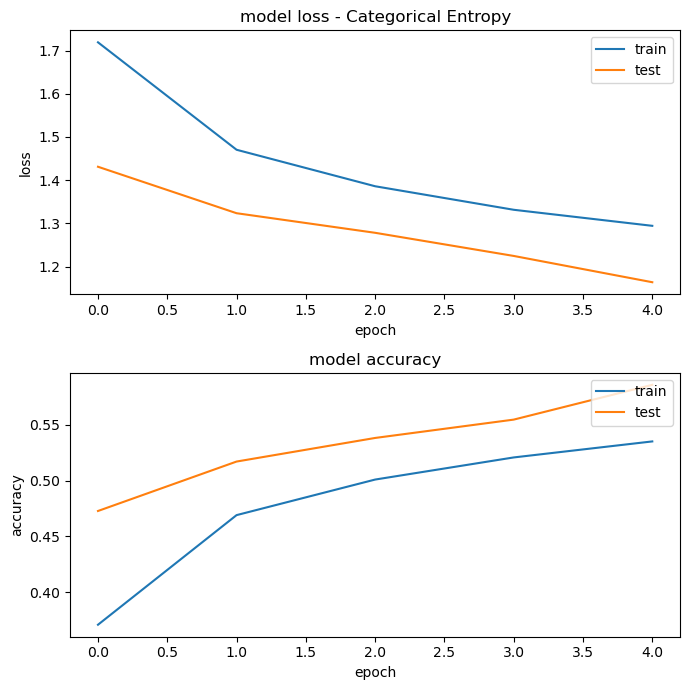

In [72]:
plt.figure(figsize = (7,7))
plt.subplot(2,1,1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss - Categorical Entropy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.subplot(2,1,2)
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.tight_layout()

In [73]:
def CNN_model_deeper():
    # define convolutional neural network model sequentially
    model = tf.keras.Sequential()
    # Feature map 1: (32x32x3) --> (16x16x64)
    model.add(layers.Conv2D(32, kernel_size=(3,3), strides=2, input_shape=[32,32,3], padding="same"))
    model.add(layers.ReLU())
    model.add(layers.Dropout(0.25))
    
    # Feature map 2: (16x16x64) --> (8x8x128)
    model.add(layers.Conv2D(64, kernel_size=(3,3), strides=2, padding="same"))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.ReLU())
    model.add(layers.Dropout(0.25))
    
    # Feature map 3: (8x8x128) --> (4x4x256)
    model.add(layers.Conv2D(128, kernel_size=(3,3), strides=2, padding="same"))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.ReLU())
    model.add(layers.Dropout(0.25))
    model.add(layers.Flatten())

    # Hidden layer 1: (4x4x256) --> 1024
    model.add(layers.Dense(512))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.ReLU())
    model.add(layers.Dropout(0.25))
    
    # Hidden layer 2: 1024 --> 512
    model.add(layers.Dense(256))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.ReLU())
    model.add(layers.Dropout(0.25))

    # Hidden layer 3: 512 --> 256
    model.add(layers.Dense(128))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.ReLU())
    model.add(layers.Dropout(0.25))
    
    # Hidden layer 4: 256 --> 128
    model.add(layers.Dense(64))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.ReLU())
    model.add(layers.Dropout(0.25))   
    
    # Output layer: 128 --> 10
    model.add(layers.Dense(10, activation = 'softmax'))   # <- Softmax is an activation function for classfier
    
    # Compile the Neural Network - define Loss and optimizer to tune the associated weights
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002)
    model.compile(loss='categorical_crossentropy', metrics=['categorical_accuracy'], optimizer=optimizer)
    return model

In [74]:
model_deep = CNN_model_deeper()
# model_deep.summary()


# training the Convolutional Neural Network and saving metrics every 100 epochs
checkpoint_filepath = 'CNN Classifier Models/CNN_Deep_Model'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_categorical_accuracy',
    mode='max',
    save_best_only=True)
history_deep = model_deep.fit(x_train_n, y_train_one_hot.todense(), 
                    batch_size=10, epochs=3, verbose=2, 
                    validation_data=(x_test_n, y_test_one_hot.todense()),
                    callbacks=[model_checkpoint_callback])

Epoch 1/3
5000/5000 - 184s - loss: 2.1110 - categorical_accuracy: 0.2342 - val_loss: 1.6588 - val_categorical_accuracy: 0.3971 - 184s/epoch - 37ms/step
Epoch 2/3
5000/5000 - 185s - loss: 1.7401 - categorical_accuracy: 0.3649 - val_loss: 1.5032 - val_categorical_accuracy: 0.4652 - 185s/epoch - 37ms/step
Epoch 3/3
5000/5000 - 178s - loss: 1.5900 - categorical_accuracy: 0.4316 - val_loss: 1.2983 - val_categorical_accuracy: 0.5311 - 178s/epoch - 36ms/step


In [75]:
model_deep.load_weights(checkpoint_filepath)   

In [76]:
y_train_predict = model_deep.predict(x_train_n)                 # predict over the training images
y_train_predict = np.argmax(y_train_predict,axis = 1)           # assign the maximum probability category

y_test_predict = model_deep.predict(x_test_n)                   # predict over the testing images 
y_test_predict = np.argmax(y_test_predict,axis = 1) 

313/313 [==============================] - 4s 14ms/step


In [77]:
print(f'precision: {accuracy_score(y_train.flatten(), y_train_predict):.4f} (for train data), {accuracy_score(y_test.flatten(), y_test_predict):.4f} (for test data)')
print(f'recall: {recall_score(y_train.flatten(), y_train_predict, average = "weighted"):.4f}(for train data), {recall_score(y_test.flatten(), y_test_predict, average = "weighted"):.4f}(for test data)')
print(f'f1 score: {f1_score(y_train.flatten(), y_train_predict, average = "weighted"):.4f}(for train data), {f1_score(y_test.flatten(), y_test_predict, average = "weighted"):.4f}(for test data)')

precision: 0.5390 (for train data), 0.5311 (for test data)
recall: 0.5390(for train data), 0.5311(for test data)
f1 score: 0.5358(for train data), 0.5266(for test data)


Text(58.222222222222214, 0.5, 'True label')

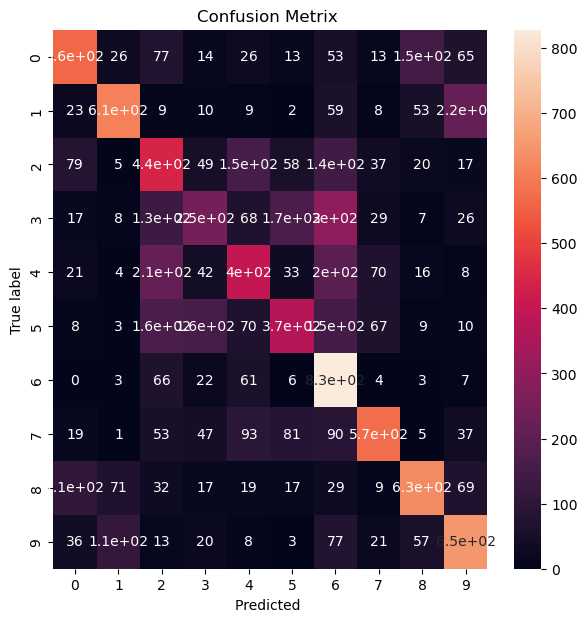

In [86]:
confusion_matrix = np.zeros((10,10))
for i in range(y_test.shape[0]):
    estimate = y_test_predict[i]
    actual  = y_test[i,0]
    confusion_matrix[actual,estimate] += 1   
# Plot Confusion Matrix
df_cm = pd.DataFrame(confusion_matrix)
plt.figure(figsize = (7,7))
sns.heatmap(df_cm, annot=True)
plt.title("Confusion Metrix ")
plt.xlabel('Predicted ')
plt.ylabel('True label')

In [79]:
import math
import cmath

def polar2rect(ampl, phase):
	phase = math.radians(phase)
	return cmath.rect(ampl, phase)
	
def sum_of_polars(ampl1, phase1, ampl2, phase2):
	number1 = polar2rect(ampl1, phase1)
	number2 = polar2rect(ampl2, phase2)
	sum = number1 + number2
	(sum_ampl, sum_phase) = cmath.polar(sum)
	return (sum_ampl, math.degrees(sum_phase))
	
def help():
	print ("COMPLEX NUMBER LIBRARY\n")
	print ("polar2rect(amplitude, phase): converts from polar (phase in degrees) to complex number\n")
	print ("sum_of_polars(ampl1, phase1, ampl2, phase2): adds two numbers with amplitudes ampl1, ampl2 and phases phase1, phase2\n")